In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

c:\Users\Arthur\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv('../Data/data.csv', index_col=0)

In [ ]:
y = data['sex']
X = data[data.columns[1:]]
# Séparation en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Séparation de l'ensemble de test en ensembles de test et de validation (60% test, 40% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4)


In [ ]:
y_train

116    1
107    1
141    1
171    1
194    0
      ..
136    0
35     1
188    1
54     0
41     0
Name: sex, Length: 192, dtype: int64

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# Fonction pour tokenizer une ligne de données
def tokenize_data(row):
    # Concaténer les données textuelles en une seule chaîne
    text = ' '.join([str(row['surname']), str(row['firstname']), str(row['age']), str(row['link']), str(row['occupation'])])
    
    # Tokenization avec DistilBERT
    tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=16, padding='max_length', truncation=True, return_tensors='pt')
    
    return tokens

tokenized_train_data = X_train.apply(tokenize_data, axis=1)
tokenized_test_data = X_test.apply(tokenize_data, axis=1)
tokenized_val_data = X_val.apply(tokenize_data, axis=1)

In [ ]:
train_encodings = tokenizer(X_train['sentence'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_val['sentence'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(X_test['sentence'].to_list(), truncation=True, padding=True)

In [ ]:
train_encodings['input_ids'][0]

[101, 22530, 3744, 16660, 16660, 16660, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
import torch

# Fonction pour préparer les données tokenizées
def prepare_dataset(tokenized_data, labels):
    input_ids = torch.cat([data['input_ids'] for data in tokenized_data], dim=0)
    attention_masks = torch.cat([data['attention_mask'] for data in tokenized_data], dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)
    return input_ids, attention_masks, labels

# Préparation des données pour l'entraînement
train_input_ids, train_attention_masks, train_labels = prepare_dataset(tokenized_train_data, y_train)

# Préparation des données pour le test
test_input_ids, test_attention_masks, test_labels = prepare_dataset(tokenized_test_data, y_test)

# Préparation des données pour la validation
val_input_ids, val_attention_masks, val_labels = prepare_dataset(tokenized_val_data, y_val)


## Nombre d'epochs : 15, assez faible mais suffisant pour que l'accuracy ne s'améliore que très peu pour chaque learning rate.

## Variation du learning rate

In [ ]:




# Définir les paramètres d'entraînement
val_accuracies_lr = []
test_accuracies_lr = []
for learning_rate in [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    device = "cpu"
    # Définir le modèle DistilBERT
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Définir les tenseurs de données d'entraînement et de validation
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

    # Définir les paramètres d'entraînement
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    # Mettre le modèle en mode d'entraînement
    model.train()

    # Boucle d'entraînement
    epochs = 15
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for batch in train_dataloader:
            # Extraire les données du batch
            input_ids, attention_masks, labels = batch
            
            # Mettre les données sur le GPU si disponible
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            # Remettre les gradients à zéro
            optimizer.zero_grad()
            
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            
            # Calculer la perte
            loss = outputs.loss
            
            # Faire une passe arrière pour calculer les gradients
            loss.backward()
            
            # Mettre à jour les poids du modèle
            optimizer.step()
            
        # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes pour l'ensemble de test
    test_predictions = []
    test_true_labels = []

    # Boucle d'évaluation sur l'ensemble de test
    for batch in test_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, dim=1).tolist())
        test_true_labels.extend(labels.tolist())

    # Calculer les performances du modèle sur l'ensemble de test
    correct_predictions = sum(p == t for p, t in zip(test_predictions, test_true_labels))
    total_predictions = len(test_predictions)
    test_accuracy = correct_predictions / total_predictions
    test_accuracies_lr.append(test_accuracy)
    print(f'learning rate:{learning_rate}')
    print(f'Accuracy on test set: {test_accuracy:.2f}')
    
    # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes
    predictions = []
    true_labels = []

    # Boucle d'évaluation
    for batch in val_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

    # Calculer les performances du modèle
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    total_predictions = len(predictions)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies_lr.append(val_accuracy)
    print(f'Accuracy on validation set: {val_accuracy:.2f}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:1e-06
Accuracy on test set: 0.93
Accuracy on validation set: 0.85


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:2e-06
Accuracy on test set: 0.96
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:3e-06
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:4e-06
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:5e-06
Accuracy on test set: 0.93
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:1e-05
Accuracy on test set: 0.96
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:2e-05
Accuracy on test set: 0.93
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:3e-05
Accuracy on test set: 0.86
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:4e-05
Accuracy on test set: 0.93
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:5e-05
Accuracy on test set: 0.96
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.0001
Accuracy on test set: 0.96
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.001
Accuracy on test set: 0.61
Accuracy on validation set: 0.45


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.01
Accuracy on test set: 0.61
Accuracy on validation set: 0.45


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.1
Accuracy on test set: 0.61
Accuracy on validation set: 0.45


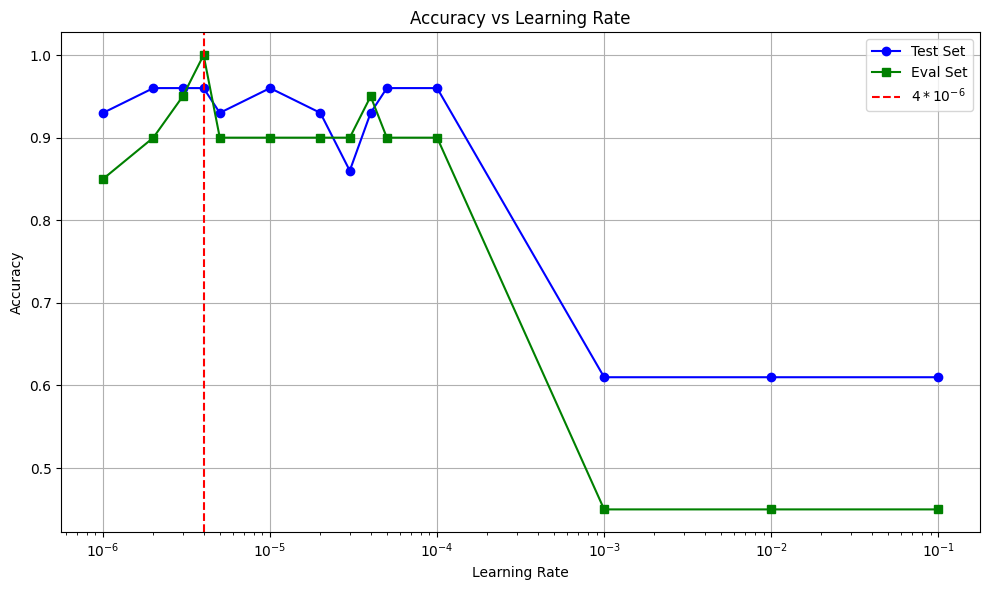

In [ ]:
# Données
test_accuracies_lr = [0.93, 0.96, 0.96, 0.96, 0.93, 0.96, 0.93, 0.86, 0.93, 0.96, 0.96, 0.61, 0.61, 0.61]
val_accuracies_lr = [0.85, 0.90, 0.95, 1, 0.9, 0.9, 0.9, 0.9, 0.95, 0.9, 0.9, 0.45, 0.45, 0.45]
learning_rates = [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Plot
plt.figure(figsize=(10, 6))  # Taille de la figure
plt.plot(learning_rates, test_accuracies_lr, label='Test Set', marker='o', color='blue')  # Courbe pour le test set
plt.plot(learning_rates, val_accuracies_lr, label='Eval Set', marker='s', color='green')  # Courbe pour l'ensemble d'évaluation
plt.xscale('log')  # Echelle logarithmique sur l'axe x pour les taux d'apprentissage
plt.axvline(x=4e-6, linestyle='--', color='red', label='$4*10^{-6}$')
plt.xlabel('Learning Rate')  # Nom de l'axe x
plt.ylabel('Accuracy')  # Nom de l'axe y
plt.title('Accuracy vs Learning Rate')  # Titre du graphique
plt.legend()  # Affichage de la légende
plt.grid(True)  # Affichage de la grille
plt.tight_layout()  # Ajustement automatique des paramètres de la figure pour s'assurer que rien n'est coupé
plt.show()  # Affichage du graphique


## Variation du batch (avec LR optimal)

In [ ]:


# Définir les paramètres d'entraînement
val_accuracies_batch = []
test_accuracies_batch = []
optimal_lr = 3e-06
for batch_size in [4, 8, 16, 32, 64, 128]:
    device = "cpu"
    # Définir le modèle DistilBERT
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=optimal_lr)

    # Définir les tenseurs de données d'entraînement et de validation
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

    # Définir les paramètres d'entraînement
    # batch_size = 16
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    # Mettre le modèle en mode d'entraînement
    model.train()

    # Boucle d'entraînement
    epochs = 15
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for batch in train_dataloader:
            # Extraire les données du batch
            input_ids, attention_masks, labels = batch
            
            # Mettre les données sur le GPU si disponible
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            # Remettre les gradients à zéro
            optimizer.zero_grad()
            
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            
            # Calculer la perte
            loss = outputs.loss
            
            # Faire une passe arrière pour calculer les gradients
            loss.backward()
            
            # Mettre à jour les poids du modèle
            optimizer.step()
            
        # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes pour l'ensemble de test
    test_predictions = []
    test_true_labels = []

    # Boucle d'évaluation sur l'ensemble de test
    for batch in test_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, dim=1).tolist())
        test_true_labels.extend(labels.tolist())

    # Calculer les performances du modèle sur l'ensemble de test
    correct_predictions = sum(p == t for p, t in zip(test_predictions, test_true_labels))
    total_predictions = len(test_predictions)
    test_accuracy = correct_predictions / total_predictions
    test_accuracies_batch.append(test_accuracy)
    print(f'batch size:{batch_size}')
    print(f'Accuracy on test set: {test_accuracy:.2f}')
    
    # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes
    predictions = []
    true_labels = []

    # Boucle d'évaluation
    for batch in val_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

    # Calculer les performances du modèle
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    total_predictions = len(predictions)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies_batch.append(val_accuracy)
    print(f'Accuracy on validation set: {val_accuracy:.2f}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:4
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:8
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:16
Accuracy on test set: 0.93
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:32
Accuracy on test set: 0.96
Accuracy on validation set: 0.90


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:64
Accuracy on test set: 0.89
Accuracy on validation set: 0.80


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
batch size:128
Accuracy on test set: 0.61
Accuracy on validation set: 0.45


## Ajout d'un weight_decay avec le LR le plus optimal

In [ ]:


# Définir les paramètres d'entraînement
val_accuracies_wd = []
test_accuracies_wd = []
optimal_lr = 3e-06
optimal_batch_size = 8
for wd in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
    device = "cpu"
    # Définir le modèle DistilBERT
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=optimal_lr, weight_decay=wd)

    # Définir les tenseurs de données d'entraînement et de validation
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

    # Définir les paramètres d'entraînement
    batch_size = optimal_batch_size
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    # Mettre le modèle en mode d'entraînement
    model.train()

    # Boucle d'entraînement
    epochs = 15
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for batch in train_dataloader:
            # Extraire les données du batch
            input_ids, attention_masks, labels = batch
            
            # Mettre les données sur le GPU si disponible
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            # Remettre les gradients à zéro
            optimizer.zero_grad()
            
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            
            # Calculer la perte
            loss = outputs.loss
            
            # Faire une passe arrière pour calculer les gradients
            loss.backward()
            
            # Mettre à jour les poids du modèle
            optimizer.step()
            
        # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes pour l'ensemble de test
    test_predictions = []
    test_true_labels = []

    # Boucle d'évaluation sur l'ensemble de test
    for batch in test_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, dim=1).tolist())
        test_true_labels.extend(labels.tolist())

    # Calculer les performances du modèle sur l'ensemble de test
    correct_predictions = sum(p == t for p, t in zip(test_predictions, test_true_labels))
    total_predictions = len(test_predictions)
    test_accuracy = correct_predictions / total_predictions
    test_accuracies_wd.append(test_accuracy)
    print(f'weight decay: {wd}')
    print(f'Accuracy on test set: {test_accuracy:.2f}')
    
    # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes
    predictions = []
    true_labels = []

    # Boucle d'évaluation
    for batch in val_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

    # Calculer les performances du modèle
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    total_predictions = len(predictions)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies_wd.append(val_accuracy)
    print(f'Accuracy on validation set: {val_accuracy:.2f}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Arthur\miniconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 0.001
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 0.0001
Accuracy on test set: 1.00
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 1e-05
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 1e-06
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 1e-07
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
weight decay: 1e-08
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


## Test du modèle avec seulement les prénoms en donnée personnelle

In [ ]:
y = data['sex']
X = data[['firstname']]
# Séparation en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Séparation de l'ensemble de test en ensembles de test et de validation (60% test, 40% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4)

y_train
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# Fonction pour tokenizer une ligne de données
def tokenize_data(row):
    # Concaténer les données textuelles en une seule chaîne
    text = str(row['firstname'])
    
    # Tokenization avec DistilBERT
    tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=16, padding='max_length', truncation=True, return_tensors='pt')
    
    return tokens

tokenized_train_data = X_train.apply(tokenize_data, axis=1)
tokenized_test_data = X_test.apply(tokenize_data, axis=1)
tokenized_val_data = X_val.apply(tokenize_data, axis=1)
train_encodings = tokenizer(X_train['firstname'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(X_val['firstname'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(X_test['firstname'].to_list(), truncation=True, padding=True)
train_encodings['input_ids'][0]
# Jouer avec le learning rate, weight decay, momentum, nombre d'epochs et plot des graphes des accuracies en fonction des valeurs de ces hyperparamètres
import torch

# Fonction pour préparer les données tokenizées
def prepare_dataset(tokenized_data, labels):
    input_ids = torch.cat([data['input_ids'] for data in tokenized_data], dim=0)
    attention_masks = torch.cat([data['attention_mask'] for data in tokenized_data], dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)
    return input_ids, attention_masks, labels

# Préparation des données pour l'entraînement
train_input_ids, train_attention_masks, train_labels = prepare_dataset(tokenized_train_data, y_train)

# Préparation des données pour le test
test_input_ids, test_attention_masks, test_labels = prepare_dataset(tokenized_test_data, y_test)

# Préparation des données pour la validation
val_input_ids, val_attention_masks, val_labels = prepare_dataset(tokenized_val_data, y_val)

## Nombre d'epochs : 15, assez faible mais suffisant pour que l'accuracy ne s'améliore que très peu pour chaque learning rate.
## Variation du learning rate




# Définir les paramètres d'entraînement
val_accuracies_lr = []
test_accuracies_lr = []
for learning_rate in [1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    device = "cpu"
    # Définir le modèle DistilBERT
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Définir les tenseurs de données d'entraînement et de validation
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

    # Définir les paramètres d'entraînement
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    # Mettre le modèle en mode d'entraînement
    model.train()

    # Boucle d'entraînement
    epochs = 15
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for batch in train_dataloader:
            # Extraire les données du batch
            input_ids, attention_masks, labels = batch
            
            # Mettre les données sur le GPU si disponible
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            # Remettre les gradients à zéro
            optimizer.zero_grad()
            
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            
            # Calculer la perte
            loss = outputs.loss
            
            # Faire une passe arrière pour calculer les gradients
            loss.backward()
            
            # Mettre à jour les poids du modèle
            optimizer.step()
            
        # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes pour l'ensemble de test
    test_predictions = []
    test_true_labels = []

    # Boucle d'évaluation sur l'ensemble de test
    for batch in test_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, dim=1).tolist())
        test_true_labels.extend(labels.tolist())

    # Calculer les performances du modèle sur l'ensemble de test
    correct_predictions = sum(p == t for p, t in zip(test_predictions, test_true_labels))
    total_predictions = len(test_predictions)
    test_accuracy = correct_predictions / total_predictions
    test_accuracies_lr.append(test_accuracy)
    print(f'learning rate:{learning_rate}')
    print(f'Accuracy on test set: {test_accuracy:.2f}')
    
    # Mettre le modèle en mode d'évaluation
    model.eval()

    # Listes pour stocker les prédictions et les vraies étiquettes
    predictions = []
    true_labels = []

    # Boucle d'évaluation
    for batch in val_dataloader:
        # Extraire les données du batch
        input_ids, attention_masks, labels = batch
        
        # Mettre les données sur le GPU si disponible
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        # Désactiver le calcul des gradients
        with torch.no_grad():
            # Faire une passe avant pour obtenir les prédictions
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            
        # Obtenir les prédictions et les étiquettes
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

    # Calculer les performances du modèle
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    total_predictions = len(predictions)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies_lr.append(val_accuracy)
    print(f'Accuracy on validation set: {val_accuracy:.2f}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Arthur\miniconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:1e-06
Accuracy on test set: 0.89
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:2e-06
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:3e-06
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:4e-06
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:5e-06
Accuracy on test set: 1.00
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:1e-05
Accuracy on test set: 1.00
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:2e-05
Accuracy on test set: 0.96
Accuracy on validation set: 0.95


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:3e-05
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:4e-05
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:5e-05
Accuracy on test set: 0.96
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.0001
Accuracy on test set: 0.93
Accuracy on validation set: 1.00


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.001
Accuracy on test set: 0.68
Accuracy on validation set: 0.55


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.01
Accuracy on test set: 0.68
Accuracy on validation set: 0.55


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
learning rate:0.1
Accuracy on test set: 0.68
Accuracy on validation set: 0.55
